In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import pandas as pd
from PIL import Image
import os

In [ ]:
# Hyperparameters
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
IMG_DIR = r"" # REPLACE WITH OWN IMAGE DIRECTORY
CSV_FILE = r"" # REPLACE WITH OWN LABEL CSV FILE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Load and preprocess dataset
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.data.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert("RGB")
        score = torch.tensor(self.data.iloc[idx, 1], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, score

In [ ]:
# Transform the data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
# Create datasets and data loaders
dataset = FundusDataset(CSV_FILE, IMG_DIR, transform=train_transforms)

# Split dataset into train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(f"Train Size: {train_size}")
print(f"Val Size: {val_size}")
print(f"Test Size: {test_size}")

Train Size: 1260
Val Size: 270
Test Size: 270


In [13]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply specific transforms to each dataset
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

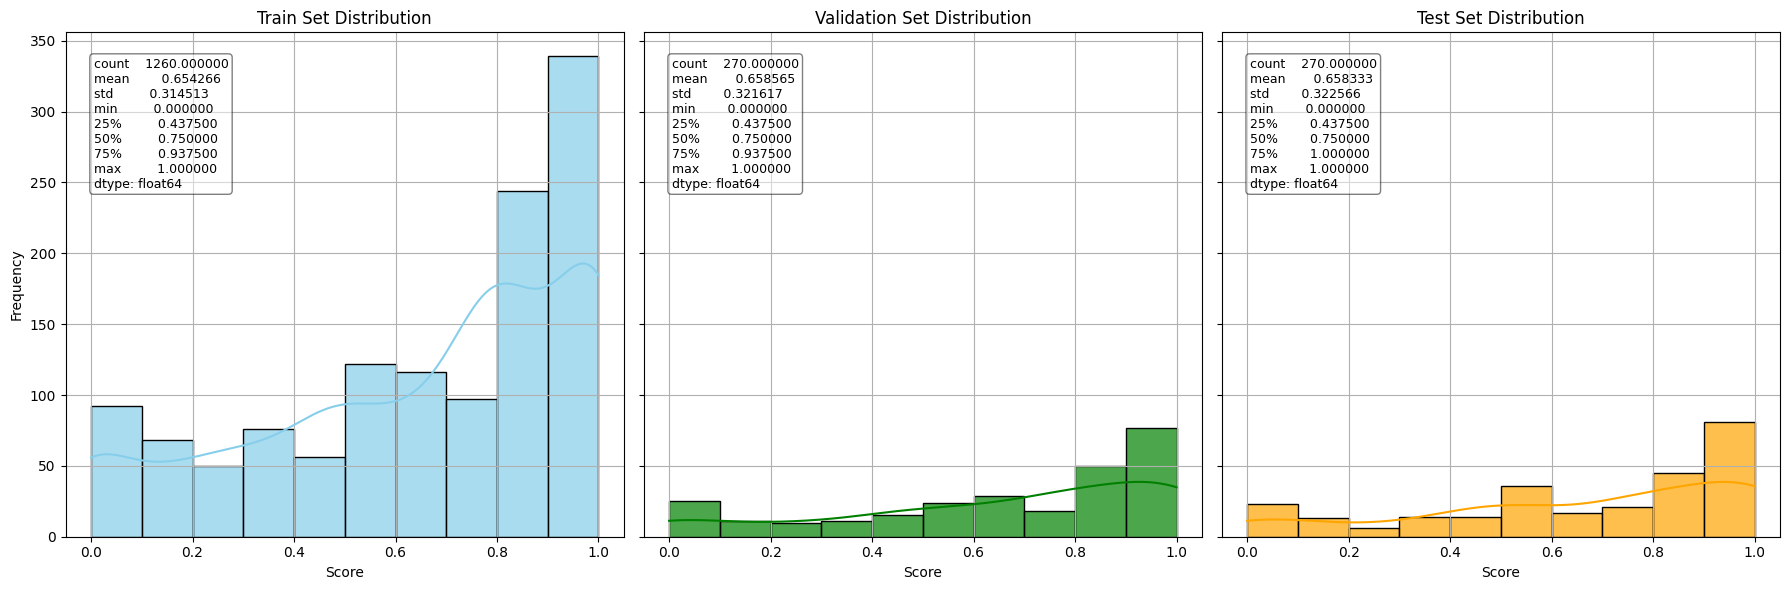

Train Set Descriptive Statistics:
count    1260.000000
mean        0.654266
std         0.314513
min         0.000000
25%         0.437500
50%         0.750000
75%         0.937500
max         1.000000
dtype: float64

Validation Set Descriptive Statistics:
count    270.000000
mean       0.658565
std        0.321617
min        0.000000
25%        0.437500
50%        0.750000
75%        0.937500
max        1.000000
dtype: float64

Test Set Descriptive Statistics:
count    270.000000
mean       0.658333
std        0.322566
min        0.000000
25%        0.437500
50%        0.750000
75%        1.000000
max        1.000000
dtype: float64


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract scores from each split
train_scores = [train_dataset[i][1].item() for i in range(len(train_dataset))]
val_scores = [val_dataset[i][1].item() for i in range(len(val_dataset))]
test_scores = [test_dataset[i][1].item() for i in range(len(test_dataset))]

# Descriptive statistics
train_stats = pd.Series(train_scores).describe()
val_stats = pd.Series(val_scores).describe()
test_stats = pd.Series(test_scores).describe()

# Plot histograms and KDEs for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Train set
sns.histplot(train_scores, bins=10, kde=True, color="skyblue", ax=axes[0], alpha=0.7)
axes[0
].set_title("Train Set Distribution")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)
axes[0].text(0.05, 0.95, f"{train_stats}", transform=axes[0].transAxes, fontsize=9, 
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Validation set
sns.histplot(val_scores, bins=10, kde=True, color="green", ax=axes[1], alpha=0.7)
axes[1].set_title("Validation Set Distribution")
axes[1].set_xlabel("Score")
axes[1].grid(True)
axes[1].text(0.05, 0.95, f"{val_stats}", transform=axes[1].transAxes, fontsize=9, 
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Test set
sns.histplot(test_scores, bins=10, kde=True, color="orange", ax=axes[2], alpha=0.7)
axes[2].set_title("Test Set Distribution")
axes[2].set_xlabel("Score")
axes[2].grid(True)
axes[2].text(0.05, 0.95, f"{test_stats}", transform=axes[2].transAxes, fontsize=9, 
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Adjust layout
plt.tight_layout()
plt.show()

# Print descriptive statistics in the console as well
print("Train Set Descriptive Statistics:")
print(train_stats)
print("\nValidation Set Descriptive Statistics:")
print(val_stats)
print("\nTest Set Descriptive Statistics:")
print(test_stats)

In [ ]:
# Model definition
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Modify for regression task
model = model.to(DEVICE)

# Loss function and optimizer 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [16]:
# Training and validation functions
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for images, scores in loader:
        images, scores = images.to(device), scores.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()

        loss = loss_fn(outputs, scores)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def validate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, scores in loader:
            images, scores = images.to(device), scores.to(device)

            outputs = model(images).squeeze()

            loss = loss_fn(outputs, scores)

            running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def test(model, loader, device):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for images, scores in loader:
            images, scores = images.to(device), scores.to(device)
            outputs = model(images).squeeze()

            predictions.extend(outputs.cpu().numpy())
            ground_truths.extend(scores.cpu().numpy())

    return predictions, ground_truths

In [31]:
# Training loop
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss = validate(model, val_loader, criterion, DEVICE)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "image_quality_grader.pth")
        print("Model saved!")

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Model saved!
Epoch 1/50, Train Loss: 0.0060, Val Loss: 0.0247
Epoch 2/50, Train Loss: 0.0050, Val Loss: 0.0287
Epoch 3/50, Train Loss: 0.0041, Val Loss: 0.0250
Model saved!
Epoch 4/50, Train Loss: 0.0043, Val Loss: 0.0223
Epoch 5/50, Train Loss: 0.0045, Val Loss: 0.0257
Epoch 6/50, Train Loss: 0.0051, Val Loss: 0.0251
Epoch 7/50, Train Loss: 0.0055, Val Loss: 0.0248
Epoch 8/50, Train Loss: 0.0042, Val Loss: 0.0231
Epoch 9/50, Train Loss: 0.0041, Val Loss: 0.0309
Epoch 10/50, Train Loss: 0.0047, Val Loss: 0.0240
Epoch 11/50, Train Loss: 0.0038, Val Loss: 0.0245
Epoch 12/50, Train Loss: 0.0036, Val Loss: 0.0237
Model saved!
Epoch 13/50, Train Loss: 0.0025, Val Loss: 0.0216
Model saved!
Epoch 14/50, Train Loss: 0.0027, Val Loss: 0.0213
Epoch 15/50, Train Loss: 0.0027, Val Loss: 0.0234
Epoch 16/50, Train Loss: 0.0042, Val Loss: 0.0256
Epoch 17/50, Train Loss: 0.0040, Val Loss: 0.0224
Model saved!
Epoch 18/50, Train Loss: 0.0031, Val Loss: 0.0206
Epoch 19/50, Train Loss: 0.0029, Val Loss: 0

In [32]:
# Test set
predictions, ground_truths = test(model, test_loader, DEVICE)

In [33]:
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    median_absolute_error
)

# Ensure ground_truths and predictions are NumPy arrays
ground_truths = np.array(ground_truths)
predictions = np.array(predictions)

# Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(ground_truths, predictions)
mae = mean_absolute_error(ground_truths, predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R² (Coefficient of Determination)
r2 = r2_score(ground_truths, predictions)

# Adjusted R²
n = len(ground_truths)  # Number of samples
p = 1  # Number of predictors (for a single output)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Mean Absolute Percentage Error (MAPE) with divide-by-zero handling
non_zero_indices = ground_truths != 0
mape = (
    np.mean(
        np.abs((ground_truths[non_zero_indices] - predictions[non_zero_indices]) / ground_truths[non_zero_indices])
    )
    * 100
)

# Symmetric Mean Absolute Percentage Error (SMAPE) with handling for zero sums
sum_abs = np.abs(ground_truths) + np.abs(predictions)
non_zero_sum_indices = sum_abs != 0
smape = (
    np.mean(
        2 * np.abs(ground_truths[non_zero_sum_indices] - predictions[non_zero_sum_indices]) / sum_abs[non_zero_sum_indices]
    )
    * 100
)

# Explained Variance Score
explained_variance = explained_variance_score(ground_truths, predictions)

# Median Absolute Error (MedAE)
medae = median_absolute_error(ground_truths, predictions)

# Print metrics
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")
print(f"Test Adjusted R²: {adjusted_r2:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test Explained Variance: {explained_variance:.4f}")
print(f"Test Median Absolute Error: {medae:.4f}")

Test MSE: 0.0268
Test MAE: 0.1112
Test RMSE: 0.1636
Test R²: 0.7418
Test Adjusted R²: 0.7409
Test MAPE: 22.26%
Test SMAPE: 37.80%
Test Explained Variance: 0.7670
Test Median Absolute Error: 0.0743


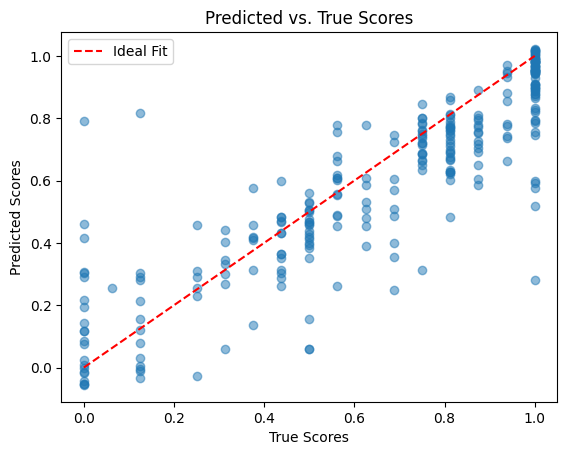

In [34]:
import matplotlib.pyplot as plt

plt.scatter(ground_truths, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('Predicted vs. True Scores')
plt.legend()
plt.show()

In [23]:
import numpy as np

errors = np.abs(np.array(ground_truths) - np.array(predictions))
large_error_indices = np.argsort(errors)[-10:]  # Indices of 5 largest errors
print("Indices of largest errors:", large_error_indices)

Indices of largest errors: [209  15 231 101  29 194 261  92 142  19]
